#**Climate Change Chatbot**

***Introduction:***
This project implements a climate change chatbot using a Transformer-based approach (BERT for embeddings) and a feed-forward neural network for classification.

***Dataset:*** Since finding a specific dataset that aligned with the chatbot's needs was difficult, a custom dataset was created by gathering FAQs about climate change from websites.

***Dataset Format:*** My dataset contains questions, answers, patterns, and tags that help in categorizing user queries.

***Workflow Overview:***

1. Load and preprocess the dataset

2. Convert data into structured intents (JSON format)

3. Use BERT embeddings to process text

4. Train a feed-forward neural network for classification


In [ ]:
# Import necessary libraries and modules
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer
from tabulate import tabulate
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Import TensorFlow and Keras modules for model building
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##**2. Load Dataset & Build Intents**

In [ ]:
# Load dataset
df = pd.read_csv("climate_chatbot_dataset.csv")
print("Dataset preview:")
print(tabulate(df.head(), headers='keys', tablefmt='psql'))


Dataset preview:
+----+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+------------------+
|    | Questions                                             | Answers                                                                                                                              | Patterns                                     | Tags             |
|----+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+------------------|
|  0 | What is climate change?                               | Climate change refers to long-term alterations in temperature, precipitation, and other atmospheric conditions on Earth.        

 **Dataset Explanation:**
1. Questions: The user query

2. Answers: The chatbot's response

3. Patterns: Alternative ways users might phrase the question

4. Tags: The category of the question (used for intent classification)


In [ ]:
# Build the intents dictionary from the dataset
intents_dict = {"intents": []}
for ind in df.index:
    # Process the 'Questions' column: lower-case, replace '?' with '.', and split by '.'
    questions = df['Questions'][ind].lower().replace('?', '.').split('.')
    # Filter empty strings and strip spaces
    patterns = [q.strip() for q in questions if q.strip()]
    # Append the additional pattern from the 'Patterns' column
    patterns.append(df['Patterns'][ind].lower().strip())

    responses = df['Answers'][ind]
    tag = df['Tags'][ind]

    # Create an intent entry with tag, patterns, and responses
    intent_entry = {
        'tags': [tag],
        'patterns': patterns,
        'responses': [responses]
    }
    intents_dict['intents'].append(intent_entry)
# Display a sample of the intents dictionary for verification
print("Intents sample:")
print(json.dumps(intents_dict["intents"][:2], indent=2))

# Save the intents dictionary as a JSON file for future use
with open("climate_change.json", "w") as f:
    json.dump(intents_dict, f)

Intents sample:
[
  {
    "tags": [
      "Climate Science"
    ],
    "patterns": [
      "what is climate change",
      "can you define climate change?"
    ],
    "responses": [
      "Climate change refers to long-term alterations in temperature, precipitation, and other atmospheric conditions on Earth."
    ]
  },
  {
    "tags": [
      "Climate Causes"
    ],
    "patterns": [
      "what causes climate change",
      "what are the main causes of climate change?"
    ],
    "responses": [
      "Climate change is primarily caused by greenhouse gas emissions from human activities such as burning fossil fuels and deforestation."
    ]
  }
]


**Why I Converted to JSON?**

- The chatbot needs structured intents where each intent has tags (labels), patterns (user inputs), and responses (bot replies).

- This format allows easy access and modification of training data.

##**3. Preprocessing & BERT Setup**

In [ ]:
# Initialize the BERT tokenizer and model using the 'bert-base-uncased' checkpoint
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize lists and parameters for processing patterns
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']
lemmatizer = WordNetLemmatizer()

def get_bert_embedding(sentence):
    """
    Generate a BERT embedding for a given sentence.
    This function tokenizes the input, processes it through BERT,
    and returns the mean of the last hidden state.
    """
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Process each intent's patterns
for intent in intents_dict['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            # Tokenize the pattern with BERT's tokenizer
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            # Store the pattern with its corresponding tag
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

# Lemmatize, filter out ignored characters, and sort unique words and classes
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Why I used BERT?**

- BERT generates meaningful contextual word embeddings, capturing sentence-level meanings rather than individual word meanings.

- This improves chatbot accuracy compared to traditional word embeddings like Word2Vec.

In [ ]:
# Save the processed words and classes for later use
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

##**4. Prepare Training Data**

In [ ]:
# Create training samples using BERT embeddings and one-hot encoded tags
training = []
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    # Get the BERT embedding for the pattern
    embedding = get_bert_embedding(pattern)
    # One-hot encode the tag
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

# Shuffle training data and convert to numpy array
random.shuffle(training)
training = np.array(training, dtype=object)

# Split training data into features and labels
train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

##**5. Build and Train the Model**

In [ ]:
# Build a feed-forward neural network model using Keras
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[1]),), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Define a learning rate schedule and the SGD optimizer
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

# Compile the model using the Adam optimizer and specify metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 46)                  │           2,990 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,678 (428.43 KB)

 Trainable params: 109,678 (428.43 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model on the prepared data
hist = model.fit(train_x, train_y, epochs=50, batch_size=12, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0317 - loss: 3.8936
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0911 - loss: 3.7947
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0143 - loss: 3.7535     
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1123 - loss: 3.7029 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0785 - loss: 3.5901 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1131 - loss: 3.4579 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1199 - loss: 3.4148 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accu

In [ ]:
# Save the trained model
model.save('chatbotmodel.h5', save_format='h5')
print('Training Done')

Training Done


##**6. Visualize Training Metrics**

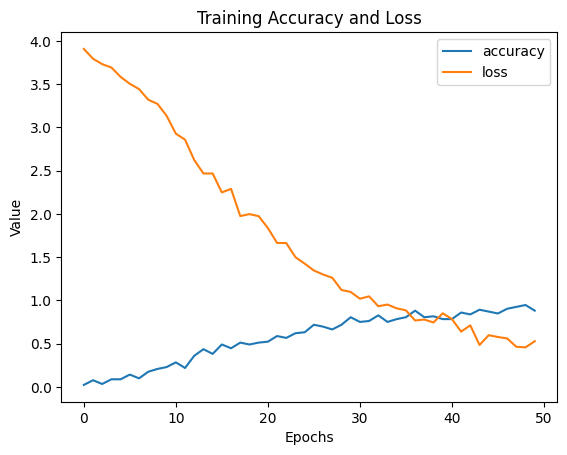

In [ ]:
# Plot training accuracy and loss over epochs
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()

**Key Observations**

1. Loss Decreasing Over Time (Orange Line)

- Loss starts high (around 4.0) and steadily decreases, meaning the model is learning and minimizing errors.
- Around epoch 40, the loss stabilizes and stops decreasing significantly. This suggests that further training may not yield significant improvements.

2. Accuracy Increasing (Blue Line)

- Accuracy starts near 0 and gradually increases, showing that the model is learning to classify intents better.
- After epoch 40, accuracy seems to plateau, meaning the model has learned most of what it can from the data.
3. Convergence Around Epoch 40

- Loss and accuracy show the most improvement before epoch 40.
- The model might not benefit much from additional epochs beyond this point.

##**7. Load Model and Chatbot Inference**

In [ ]:
# Load the saved model for prediction
model = load_model('chatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.35
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)

    # Debugging: Print predicted intent and confidence
    if results:
        print(f"Predicted Intent: {classes[results[0][0]]}, Confidence: {results[0][1]}")
        return [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    else:
        print("Low confidence prediction. No suitable intent found.")
        return []

def get_response(intents_list, intents_json):
    """
    Return a response based on the predicted intent.
    The response is chosen randomly from the list of responses corresponding to the intent.
    """
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

# Chatbot Interaction Loop
print("ChatBot is Active. Type your questions below (type 'exit' or 'quit' to stop):")
while True:
    message = input("You: ")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye!")
        break
    intents = predict_class(message)
    if intents:
        response = get_response(intents, intents_dict)
        print(f"Bot: {response}")
    else:
        print("Bot: Sorry, I don't understand.")

ChatBot is Active. Type your questions below (type 'exit' or 'quit' to stop):
You: hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Low confidence prediction. No suitable intent found.
Bot: Sorry, I don't understand.
You: is climate change deadly?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Intent: Health & Climate, Confidence: 0.3537728488445282
Bot: Climate change increases health risks such as heat-related illnesses, respiratory diseases, and the spread of infectious diseases.
You: what is climate change
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Intent: Climate Science, Confidence: 0.8560827970504761
Bot: Climate change refers to long-term alterations in temperature, precipitation, and other atmospheric conditions on Earth.
You: what are the effects of climate change?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Intent: Climate Effects, Confidence: 0.4918605089187622
Bot: Effects of climate change include rising temperatures, melting glaciers, extreme weather events, and loss 